# Project: Measuring Causal Relations with Python

## Task 1: Import Libraries 

In [1]:
# math and stats
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression

# graphs 
import graphviz
import networkx as nx 

# causality
from dowhy import CausalModel
from castle.algorithms import PC
from castle.common.priori_knowledge import PrioriKnowledge

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

# other tools
import pandas as pd
from IPython.display import display_png
import pprint

import sys
sys.path.append('workspaces/causal-relations/')
from colors import bcolors as bc

import logging
logging.getLogger().setLevel(logging.WARNING)

ModuleNotFoundError: No module named 'statsmodels'

## Task 2: Load the Dataset

The causality dataset comprises the following attributes:

- `treat`: This represents the treatment status (`1` = treated, `0` = control).
- `age`: This represents age measured in years.
- `educ`: This represents education measured in years.
- `black`: This represents race (`1` if black, `0` otherwise).
- `hisp`: This represents race (`1` if Hispanic, `0` otherwise).
- `married`: This represents marital status (`1` if married, `0` otherwise).
- `nodegr`: This represents the high school diploma status (`1` if no degree, `0` otherwise).
- `re19`: This represents real earnings in 2019.
- `re20`: This represents real earnings in 2020.
- `re22`: This represents real earnings in 2022.

In [35]:
# Load the dataset
data = pd.read_csv("/workspaces/causal-relations/data.csv")
# Print the first five frows of the dataset
data.head()

,treat,age,hisp,black,married,educ,nodegr,re19,re20,re22
0,1,29,0,0,1,13.0,0,28221,28072,44686
1,0,48,0,1,0,8.0,1,38135,38674,43367
2,1,21,0,0,1,9.0,0,27193,27913,41550
3,0,50,0,0,0,12.0,1,41695,42696,38669
4,1,49,1,0,0,10.8,0,25159,24935,47043


## Task 3: Explore the Dataset

treat      0
age        0
hisp       0
black      0
married    0
educ       0
nodegr     0
re19       0
re20       0
re22       0
dtype: int64


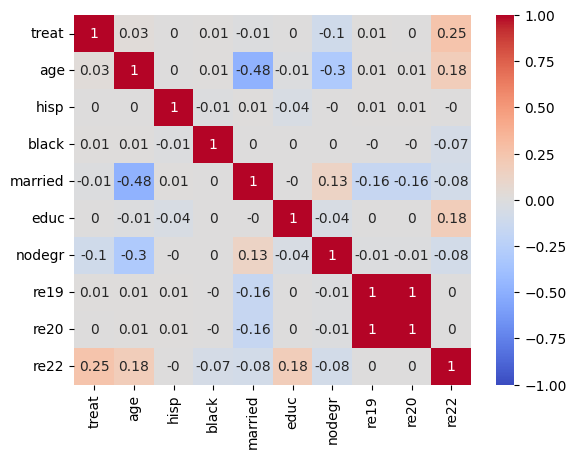

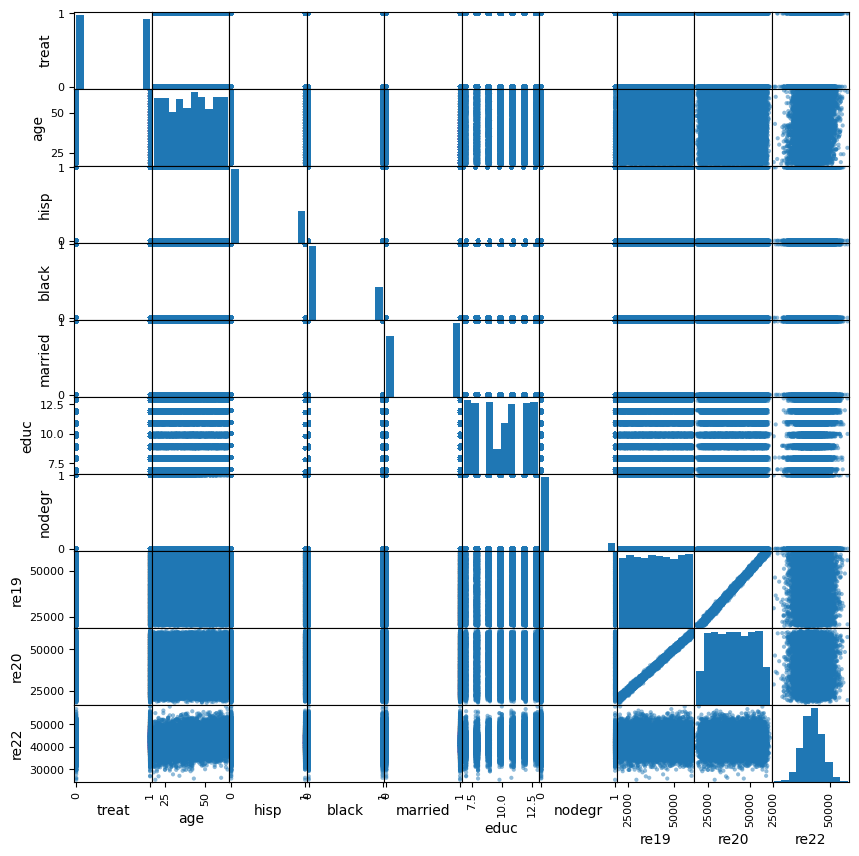

In [36]:
# Check for the missing values 
print(data.isna().sum())
# Print a convise summary of the DataFrame
data.describe()
# Create a correlation matrix
correlation_matrix = data.corr().round(2)
# Plot a heatmap to visualize the correlation
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.show()
# Plot the scatter matrix
pd.plotting.scatter_matrix(data, figsize=(10, 10))
plt.show()

## Task 4: Build Causal Graphical Models using DAGs

`list(data)`: This assumes data is an iterable (like a list, tuple, or dictionary). If data is a dictionary, `list(data)` will give you a list of its keys.

`range(len(list(data)))`: This generates a sequence of numbers from 0 to `len(list(data)) - 1`. Essentially, it creates a list of indices corresponding to the elements in data.

`zip(range(len(list(data))), list(data))`: This pairs each index with the corresponding element (or key) from data.

Dictionary Comprehension: `{k: v for k, v in zip(...)}` creates a dictionary where each index from the range is mapped to the corresponding element (or key) from data.

In [37]:
# Create a dictionary that maps numbers to the names of variables and its inverse
mapping = {k: v for k, v in zip(range(len(list(data))), list(data))}
invserse_mapping = {v: k for k, v in mapping.items()}

pprint.pprint(mapping)
print('----------------')
pprint.pprint(invserse_mapping)


{0: 'treat',
 1: 'age',
 2: 'hisp',
 3: 'black',
 4: 'married',
 5: 'educ',
 6: 'nodegr',
 7: 're19',
 8: 're20',
 9: 're22'}
----------------
{'age': 1,
 'black': 3,
 'educ': 5,
 'hisp': 2,
 'married': 4,
 'nodegr': 6,
 're19': 7,
 're20': 8,
 're22': 9,
 'treat': 0}


In [38]:
# Create a dictionary that maps numbers to the names of variables and its inverse
mapping = {k: v for k, v in zip(range(len(list(data))), list(data))}
inverse_mapping = {v: k for k, v in mapping.items()}

# Instantiate and encode priori knowledge
priori_knowledge = PrioriKnowledge(len(list(data)))
required_edges = [
    ('educ', 're22'),
    ('age', 're22'),
    ('nodegr', 're22')
    ]
#Convert edges from variable names to indices using inverse_mapping.
required_edges=[(inverse_mapping[edge[0]], inverse_mapping[edge[1]]) for edge in required_edges]
forbidden_edges = [
    ('treat', 're19'),
    ('treat', 're20'),
    ('black', 'hisp'),
    ('black', 'age'),
    ('age', 'black'),
    ('hisp', 'black'),
    ('educ', 'black'),
    ('educ', 'hisp'),
    ('re22', 're19'),
    ('re22', 're20'),
    ('re20', 're19'),
    ('treat', 'nodegr')
    ]
forbidden_edges=[(inverse_mapping[edge[0]], inverse_mapping[edge[1]]) for edge in forbidden_edges]

priori_knowledge.add_required_edges(required_edges)
priori_knowledge.add_forbidden_edges(forbidden_edges)

# Learn the causal graph using the PC algorithm
pc = PC(priori_knowledge=priori_knowledge)
pc.learn(data)

# Get the predicted causal matrix and convert it to a directed graph
pred_dag = pc.causal_matrix
g_pred = nx.DiGraph(pred_dag)
g_pred = nx.relabel_nodes(g_pred, mapping, copy=True)

### Visualize 

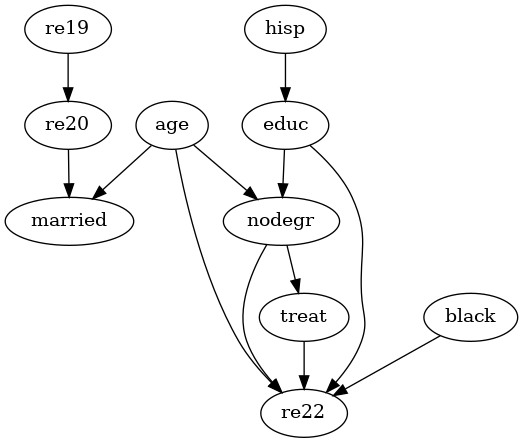

In [39]:
# Create a graph:
dag = graphviz.Digraph()
for edge in g_pred.edges:
    dag.edge(edge[0],edge[1])
display_png(dag)

# List variables to control for
variables=['treat','nodegr','black', 'age', 'educ']

## Task 6: Linear Regression for Causal Inference

In [40]:
# Select the right variables:
X = data[variables]

# Perform a linear regression:
X = sm.add_constant(X)
y = data['re22']

model = sm.OLS(y,X)
results = model.fit()

# Print a model summary:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                   re22   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.130
Method:                 Least Squares   F-statistic:                     300.4
Date:                Sun, 15 Dec 2024   Prob (F-statistic):          1.87e-300
Time:                        07:53:37   Log-Likelihood:                -97193.
No. Observations:               10000   AIC:                         1.944e+05
Df Residuals:                    9994   BIC:                         1.944e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.538e+04    251.278    140.797      0.0

## Task 7: Use Instrumental Methods to Measure Causality

For this task, use an instrumental variable (`hisp`) to estimate the causal effect of educ on `re22`.

You’ll use `hisp` because:
- It’s associated with `educ`.
- It doesn’t affect `re22` other than through `educ`.
- There are no common causes of `hisp` and `re22`.

To do this, you need to:
- Fit a linear regression of re22 as a function of hisp.
- Fit a linear regression of re22 as a function of educ.
- Divide the coefficient of the first model by the coefficient of the second model.

The purpose of this task is to compare the relative impact of two different independent variables (`hisp` and `educ`) on the dependent variable (`re22`). By calculating the ratio of the coefficients, you can assess which variable has a larger effect on `re22` in terms of the units of measurement used in the dataset. This can be useful for understanding the relative importance of these predictors in explaining the variation in the outcome variable.


In [41]:
# Perform a linear regression on `re22` as a function of `hisp`
X = data['hisp']
X = sm.add_constant(X)
y = data['re22']

model = sm.OLS(y,X)
results = model.fit()
coef1 = results.params['hisp']

# Perform a linear regression on `re22` as a function of `educ`
X = data['educ']
X = sm.add_constant(X)
y = data['re22']

model = sm.OLS(y,X)
results = model.fit()
coef2 = results.params['educ']

# Get the ratio between the two coefficients
coef3 = coef1/coef2
print('Ratio between correlation coefficient for hisp vs correlation coefficient for educ: ', bc.BLUE, coef3)

Ratio between correlation coefficient for hisp vs correlation coefficient for educ:   -0.11305040636883229


# ⚠️ Task 8: Distance Matching
Distance matching is a specific technique used for matching treated and control units (individuals or observations) to balance covariates (confounding variables) between the two groups. The idea is to find units in the control group that are “close” to the treated units in terms of their covariate values.

**Distance Metric**: The term distance refers to a measure of dissimilarity or similarity between units based on their covariate values. Common distance metrics include Euclidean distance, Mahalanobis distance, propensity score distance, etc.
Matching Algorithm: Once you have a distance metric, you can use a matching algorithm to pair treated and control units with similar covariate values. This helps create comparable groups and reduces the bias due to confounding variables.
After matching, you can estimate the causal effect such as the average treatment effect (ATE) within the matched groups. By ensuring balance in covariates, you can make the assumption that any observed differences in the outcome between the treated and control groups are more likely to be due to the treatment itself, rather than confounding variables.

To do distance matching with the DoWhy library, complete the following steps:

Generate a graph in the format accepted by DoWhy.
- Create the model.
- Get the estimand.
- Get the estimate using distance matching.

In [42]:
# Generate the graph
nodes = list(g_pred.nodes)
edges = list(g_pred.edges)

print(nodes)
print('------------------------')
print(edges)

['treat', 'age', 'hisp', 'black', 'married', 'educ', 'nodegr', 're19', 're20', 're22']
------------------------
[('treat', 're22'), ('age', 'married'), ('age', 'nodegr'), ('age', 're22'), ('hisp', 'educ'), ('black', 're22'), ('educ', 'nodegr'), ('educ', 're22'), ('nodegr', 'treat'), ('nodegr', 're22'), ('re19', 're20'), ('re20', 'married')]


In [43]:
gml_string = 'graph [directed 1\n'
for node in nodes:
    gml_string += f'\tnode [id "{node}" label "{node}"]\n'
for edge in edges:
    gml_string += f'\tedge [source "{edge[0]}" target"{edge[1]}"]\n'
gml_string += ']'

# Create the model
model = CausalModel(
    data=data,
    treatment='treat',
    outcome='re22',
    graph=gml_string
)

# Get the estimand
estimand = model.identify_effect()

# Get the estimate (distance matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.distance_matching',
    target_units='ate'
)

print('Estimate using distance matching: ', bc.BLUE, estimate.value)

Estimate using distance matching:   -1026.3381


## Task 9: Propensity Score

The propensity score is a calculated probability that helps balance the influence of different factors when studying the effects of a treatment.

Instead of dealing with all these factors individually, you can calculate the propensity score, which is a summary of how likely someone is to receive the treatment based on their existing characteristics (like age, gender, etc.).

This score simplifies the analysis because you can then focus on comparing outcomes between groups with similar propensity scores, making it easier to draw meaningful conclusions about the treatment’s impact.

There are three ways to match using the propensity score: stratification, matching, and weighting. To complete this task, get the estimate for ATE in all three ways:
- Using stratification, with `backdoor.propensity_score_stratification`
- Using matching, with `backdoor.propensity_score_matching`
- Using weighting, with `backdoor.propensity_score_weighting`


In [46]:
# Get estimate (Stratification)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_stratification',
    target_units='ate'
    )
print('Estimate for ATE using stratification', bc.BLUE, estimate.value, bc.ENDC)

# Get estimate (Matching)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_matching',
    target_units='ate'
    )
print('Estimate for ATE using matching', bc.BLUE, estimate.value, bc.ENDC)

# Get estimate (Weighting)
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.propensity_score_weighting',
    target_units='ate'
    )
print('Estimate for ATE using weighting', bc.BLUE, estimate.value, bc.ENDC)

Estimate for ATE using stratification  2121.1327843698787 
Estimate for ATE using matching  1344.1307 
Estimate for ATE using weighting  2121.424998882656 


## Task 10: Calculate Doubly Robust Estimations

In [54]:
from dowhy import CausalModel

# Assuming data, treatment, outcome, and graph are defined
model = CausalModel(
    data=data,
    treatment='treat',
    outcome='re22',
    graph=gml_string
)

# Identify the causal effect
estimand = model.identify_effect()

# Estimate the causal effect
estimate = model.estimate_effect(
    identified_estimand=estimand,
    method_name='backdoor.econml.dr.LinearDRLearner',
    target_units='ate',
    method_params={
        'init_params': {
            'model_propensity': LogisticRegression(),
            'model_regression': LinearRegression()
        },
        'fit_params': {}
    }
)

print(estimate.value)

2024-12-15 08:10:31,165 - /workspaces/causal-relations/.venv/lib/python3.12/site-packages/dowhy/causal_model.py[line:614] - WARNING: There are an additional 14 variables in the dataset that are not in the graph. Variable names are: '['cips_normalized_weight', 'cips_stabilized_weight', 'cips_weight', 'd_y', 'dbar', 'dbar_y', 'ips_normalized_weight', 'ips_stabilized_weight', 'ips_weight', 'propensity_score', 'strata', 'tips_normalized_weight', 'tips_stabilized_weight', 'tips_weight']'


ImportError: Error loading econml.dr.LinearDRLearner. Double-check the method name and ensure that all econml dependencies are installed.